# A keras model

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.layers.recurrent import LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tqdm import tqdm

from preprocess import *
from util import *

In [40]:
#TODO: shift data down to 0-89 instead of 19-...
NUM_POSSIBLE_ACTIONS = len(pitchToTuple(SILENCE, ambitus=(HIGHEST_PITCH-LOWEST_PITCH)*2))
EMBEDDING_DIMENSIONS=100
#MIN_SONG_LENGTH=200 #TODO figure out/look up

In [41]:
NUM_SONGS = 900

sop = useNumberHolds(loadData('Soprano')[:NUM_SONGS])
min_song_length = min(len(song) for song in sop) // 4 * 4 #trim to last measure
data = np.array([song[:min_song_length] for song in sop])


bass = useNumberHolds(loadData('Bass')[:NUM_SONGS])
trimmed_categorical_bass = [to_categorical(np.array(song[:min_song_length])-LOWEST_PITCH, nb_classes=NUM_POSSIBLE_ACTIONS) for song in bass]
labels = np.array(trimmed_categorical_bass)


In [42]:
data.shape

(900, 80)

In [43]:


model = Sequential()

model.add(Embedding(NUM_POSSIBLE_ACTIONS, EMBEDDING_DIMENSIONS, input_length=min_song_length))

model.add(LSTM(EMBEDDING_DIMENSIONS, return_sequences=True))
model.add(LSTM(EMBEDDING_DIMENSIONS, return_sequences=True))
model.add(LSTM(EMBEDDING_DIMENSIONS, return_sequences=True))
model.add(LSTM(EMBEDDING_DIMENSIONS, return_sequences=True))

#model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(NUM_POSSIBLE_ACTIONS)))

print(model.output_shape)
model.add(Activation('softmax'))

# Binary crossentropy?
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])



(None, 80, 178)


In [50]:


model.fit(data, labels, nb_epoch=20, batch_size=32)

Epoch 1/20
900/900 [==============================] - 12s - loss: 0.0248 - acc: 0.9946    
Epoch 2/20
900/900 [==============================] - 13s - loss: 0.0246 - acc: 0.9946    
Epoch 3/20
900/900 [==============================] - 13s - loss: 0.0244 - acc: 0.9946    
Epoch 4/20
900/900 [==============================] - 12s - loss: 0.0242 - acc: 0.9946    
Epoch 5/20
900/900 [==============================] - 14s - loss: 0.0241 - acc: 0.9946    
Epoch 6/20
900/900 [==============================] - 14s - loss: 0.0241 - acc: 0.9946    
Epoch 7/20
900/900 [==============================] - 15s - loss: 0.0240 - acc: 0.9946    
Epoch 8/20
900/900 [==============================] - 11s - loss: 0.0236 - acc: 0.9946    
Epoch 9/20
900/900 [==============================] - 13s - loss: 0.0230 - acc: 0.9946    
Epoch 10/20
900/900 [==============================] - 14s - loss: 0.0226 - acc: 0.9946    
Epoch 11/20
900/900 [==============================] - 11s - loss: 0.0223 - acc: 0.9946  

In [52]:
output=model.predict(data[11, np.newaxis])
print(output.shape)
song_pitches = np.array([np.argmax(output[0, time, :]) for time in range(output.shape[1])])+LOWEST_PITCH
print(song_pitches)

(1, 80, 178)
[ 19  19  19  19  19  19  55 144  48 137  55 144  55 140  50 139  48 137
  55 144  48 137  55 144  48 146  52 146  55 139  57 146  50 139  57 146
  45 141  45 139  54 139  48 137  50 139  48 137  50 139  48 137  48 142
  50 135  48 142  55 135  51 140  48 142  46 140  51 140  48 142  46 135
  55 135  48 142  46 135  48 142]


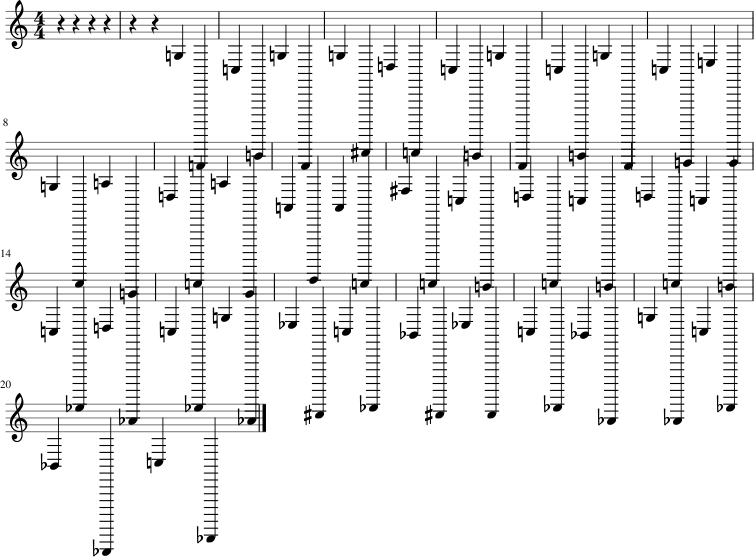

In [53]:
import util
import imp; imp.reload(util)
util.pitchToStream(song_pitches).show()